# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    monkey_defs = params.monkey_defs
    mouse_defs = params.mouse_defs

    os.chdir(RepoPath / 'monkey')
    %run "_dataset-selection.ipynb"
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
finally:
    os.chdir(nbPath)

    
n_components = min(monkey_defs.n_components, mouse_defs.n_components)

if "__file__" not in dir():
    reload(dt)
    reload(mouse_defs)
    reload(monkey_defs)
    
    print('Done!')

the variable `GoodDataList` contains the session names
Done!


# reading data

In [2]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = mouse_defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

In [3]:
warnings.filterwarnings("ignore")
allDFs_MCx = []
for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    for session in sessionList:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

# Alignment across mice and monkeys

## MCx

In [4]:
pairDfM1 = []
for I, monkey_df in enumerate(allDFs_MCx):
    for J, mouse_df in enumerate(AllDFs):
        pairDfM1.append((monkey_df,mouse_df))

print(f'{len(pairDfM1)=}')

len(pairDfM1)=126


In [5]:
side1df = [monkey for monkey,_ in pairDfM1]
side2df = [mouse for _,mouse in pairDfM1]

warnings.filterwarnings("ignore")
AllData_monkey = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=n_components)
AllData_mouse = dt.get_data_array(side2df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=n_components)
warnings.filterwarnings("default")

allCCs=[]
for sessionData1,sessionData2 in zip(AllData_monkey,AllData_mouse):
    # concatenate the targets along the trials
    data1 = np.reshape(sessionData1, (-1,*sessionData1.shape[2:]))
    data2 = np.reshape(sessionData2, (-1,*sessionData2.shape[2:]))
    min_trials, min_time,_ = np.min((data2.shape,data1.shape),axis=0)

    r = []
    for _ in range(params.n_iter):
        # shuffle the trial x target axis
        params.rng.shuffle(data1,axis=0)
        params.rng.shuffle(data2,axis=0)
        data1_ = np.reshape(data1[:min_trials,:min_time,:], (-1,n_components))
        data2_ = np.reshape(data2[:min_trials,:min_time,:], (-1,n_components))
        r.append(dt.canoncorr(data1_, data2_))
    allCCs.append(np.mean(np.array(r), axis=0))
allCCs = np.array(allCCs).T


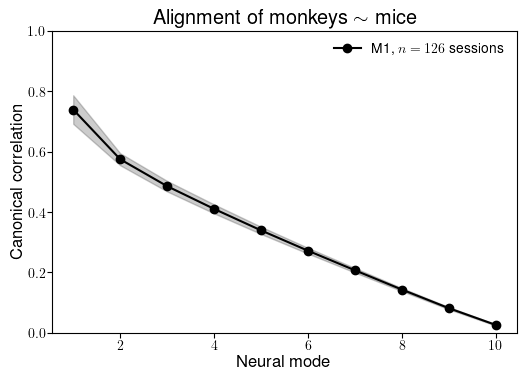

In [6]:
# plot
_,ax = plt.subplots(dpi=100)
utility.shaded_errorbar(ax, np.arange(1,n_components+1), allCCs, color='k', marker = 'o', label=f'{monkey_defs.areas[0]}, $n={allCCs.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('Neural mode')
ax.legend()
ax.set_ylabel('Canonical correlation')
ax.set_title(r'Alignment of monkeys $\sim$ mice');

## Align across dissimilar epochs

In [18]:
side1df = [monkey for monkey,_ in pairDfM1]
side2df = [mouse for _,mouse in pairDfM1]

warnings.filterwarnings("ignore")
AllData_monkey = dt.get_data_array(side1df, monkey_defs.fixation_epoch, area=monkey_defs.areas[2], model=n_components)
AllData_mouse = dt.get_data_array(side2df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=n_components)
warnings.filterwarnings("default")

allCCs_dissimilar=[]
for sessionData1,sessionData2 in zip(AllData_monkey,AllData_mouse):
    # concatenate the targets along the trials
    data1 = np.reshape(sessionData1, (-1,*sessionData1.shape[2:]))
    data2 = np.reshape(sessionData2, (-1,*sessionData2.shape[2:]))
    min_trials, min_time,_ = np.min((data2.shape,data1.shape),axis=0)
    
    r = []
    for _ in range(params.n_iter):
        # shuffle the trial x target axis
        params.rng.shuffle(data1,axis=0)
        params.rng.shuffle(data2,axis=0)
        data1_ = np.reshape(data1[:min_trials,:min_time,:], (-1,n_components))
        data2_ = np.reshape(data2[:min_trials,:min_time,:], (-1,n_components))
        r.append(dt.canoncorr(data1_, data2_))
    allCCs_dissimilar.append(np.mean(np.array(r), axis=0))
allCCs_dissimilar = np.array(allCCs_dissimilar).T

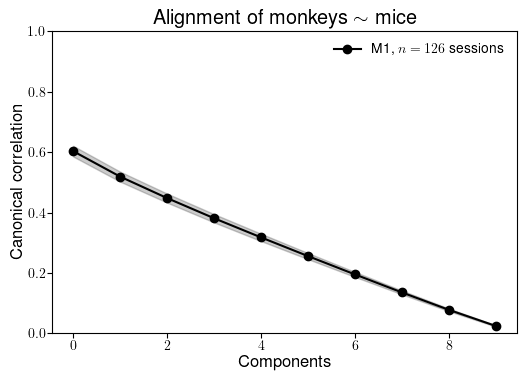

In [21]:
# plot
_,ax = plt.subplots(dpi=100)
utility.shaded_errorbar(ax, allCCs_dissimilar, color='k', marker = 'o', label=f'{monkey_defs.areas[0]}, $n={allCCs_dissimilar.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('Components')
ax.legend()
ax.set_ylabel('Canonical correlation')
ax.set_title(r'Alignment of monkeys $\sim$ mice');

## Align across target-matched trials

In [6]:
side1df = [monkey for monkey,_ in pairDfM1]
side2df = [mouse for _,mouse in pairDfM1]

targeted_df =[]
for df in side1df:
    # only keep the target in thee front of the monkey
    # df_ = pyal.select_trials(df, df.target_direction < np.pi/1.5)
    # df_ = pyal.select_trials(df_, df_.target_direction > np.pi/3)
    df_ = pyal.select_trials(df, df.target_id ==5)

    targeted_df.append(df_)


In [7]:
warnings.filterwarnings("ignore")
AllData_monkey = dt.get_data_array(targeted_df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=n_components)
AllData_mouse = dt.get_data_array(side2df, mouse_defs.exec_epoch, area=mouse_defs.areas[0], model=n_components)
warnings.filterwarnings("default")

allCCs_target_match=[]
for sessionData1,sessionData2 in zip(AllData_monkey,AllData_mouse):
    # concatenate the targets along the trials
    data1 = np.reshape(sessionData1, (-1,*sessionData1.shape[2:]))
    data2 = np.reshape(sessionData2, (-1,*sessionData2.shape[2:]))
    min_trials, min_time,_ = np.min((data2.shape,data1.shape),axis=0)
    
    r = []
    for _ in range(params.n_iter):
        # shuffle the trial x target axis
        params.rng.shuffle(data1,axis=0)
        params.rng.shuffle(data2,axis=0)
        data1_ = np.reshape(data1[:min_trials,:min_time,:], (-1,n_components))
        data2_ = np.reshape(data2[:min_trials,:min_time,:], (-1,n_components))
        r.append(dt.canoncorr(data1_, data2_))
    allCCs_target_match.append(np.mean(np.array(r), axis=0))
allCCs_target_match = np.array(allCCs_target_match).T

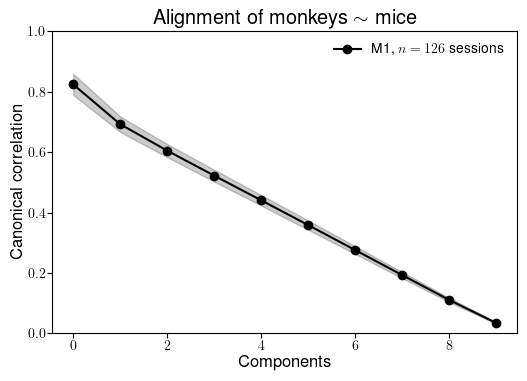

In [8]:
# plot
_,ax = plt.subplots(dpi=100)
utility.shaded_errorbar(ax, allCCs_target_match, color='k', marker = 'o', label=f'{monkey_defs.areas[0]}, $n={allCCs_target_match.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('Components')
ax.legend()
ax.set_ylabel('Canonical correlation')
ax.set_title(r'Alignment of monkeys $\sim$ mice');

## compare to lower bound of cca in mice and monkeys

load lower bounds

In [7]:
try:
    os.chdir(params.repoPath / 'monkey')
    %run "_lower-bound.ipynb"
    monkey_lower = CC_lower_bound_MCx
    
    os.chdir(params.repoPath / 'mouse')
    %run "_mouse-lower-bound.ipynb"
    mouse_lower = CC_lower_bound_M1
finally:
    os.chdir(params.repoPath / 'common')


variables: `CC_lower_bound_M1` and `CC_lower_bound_Str` hold the lower bound correlations


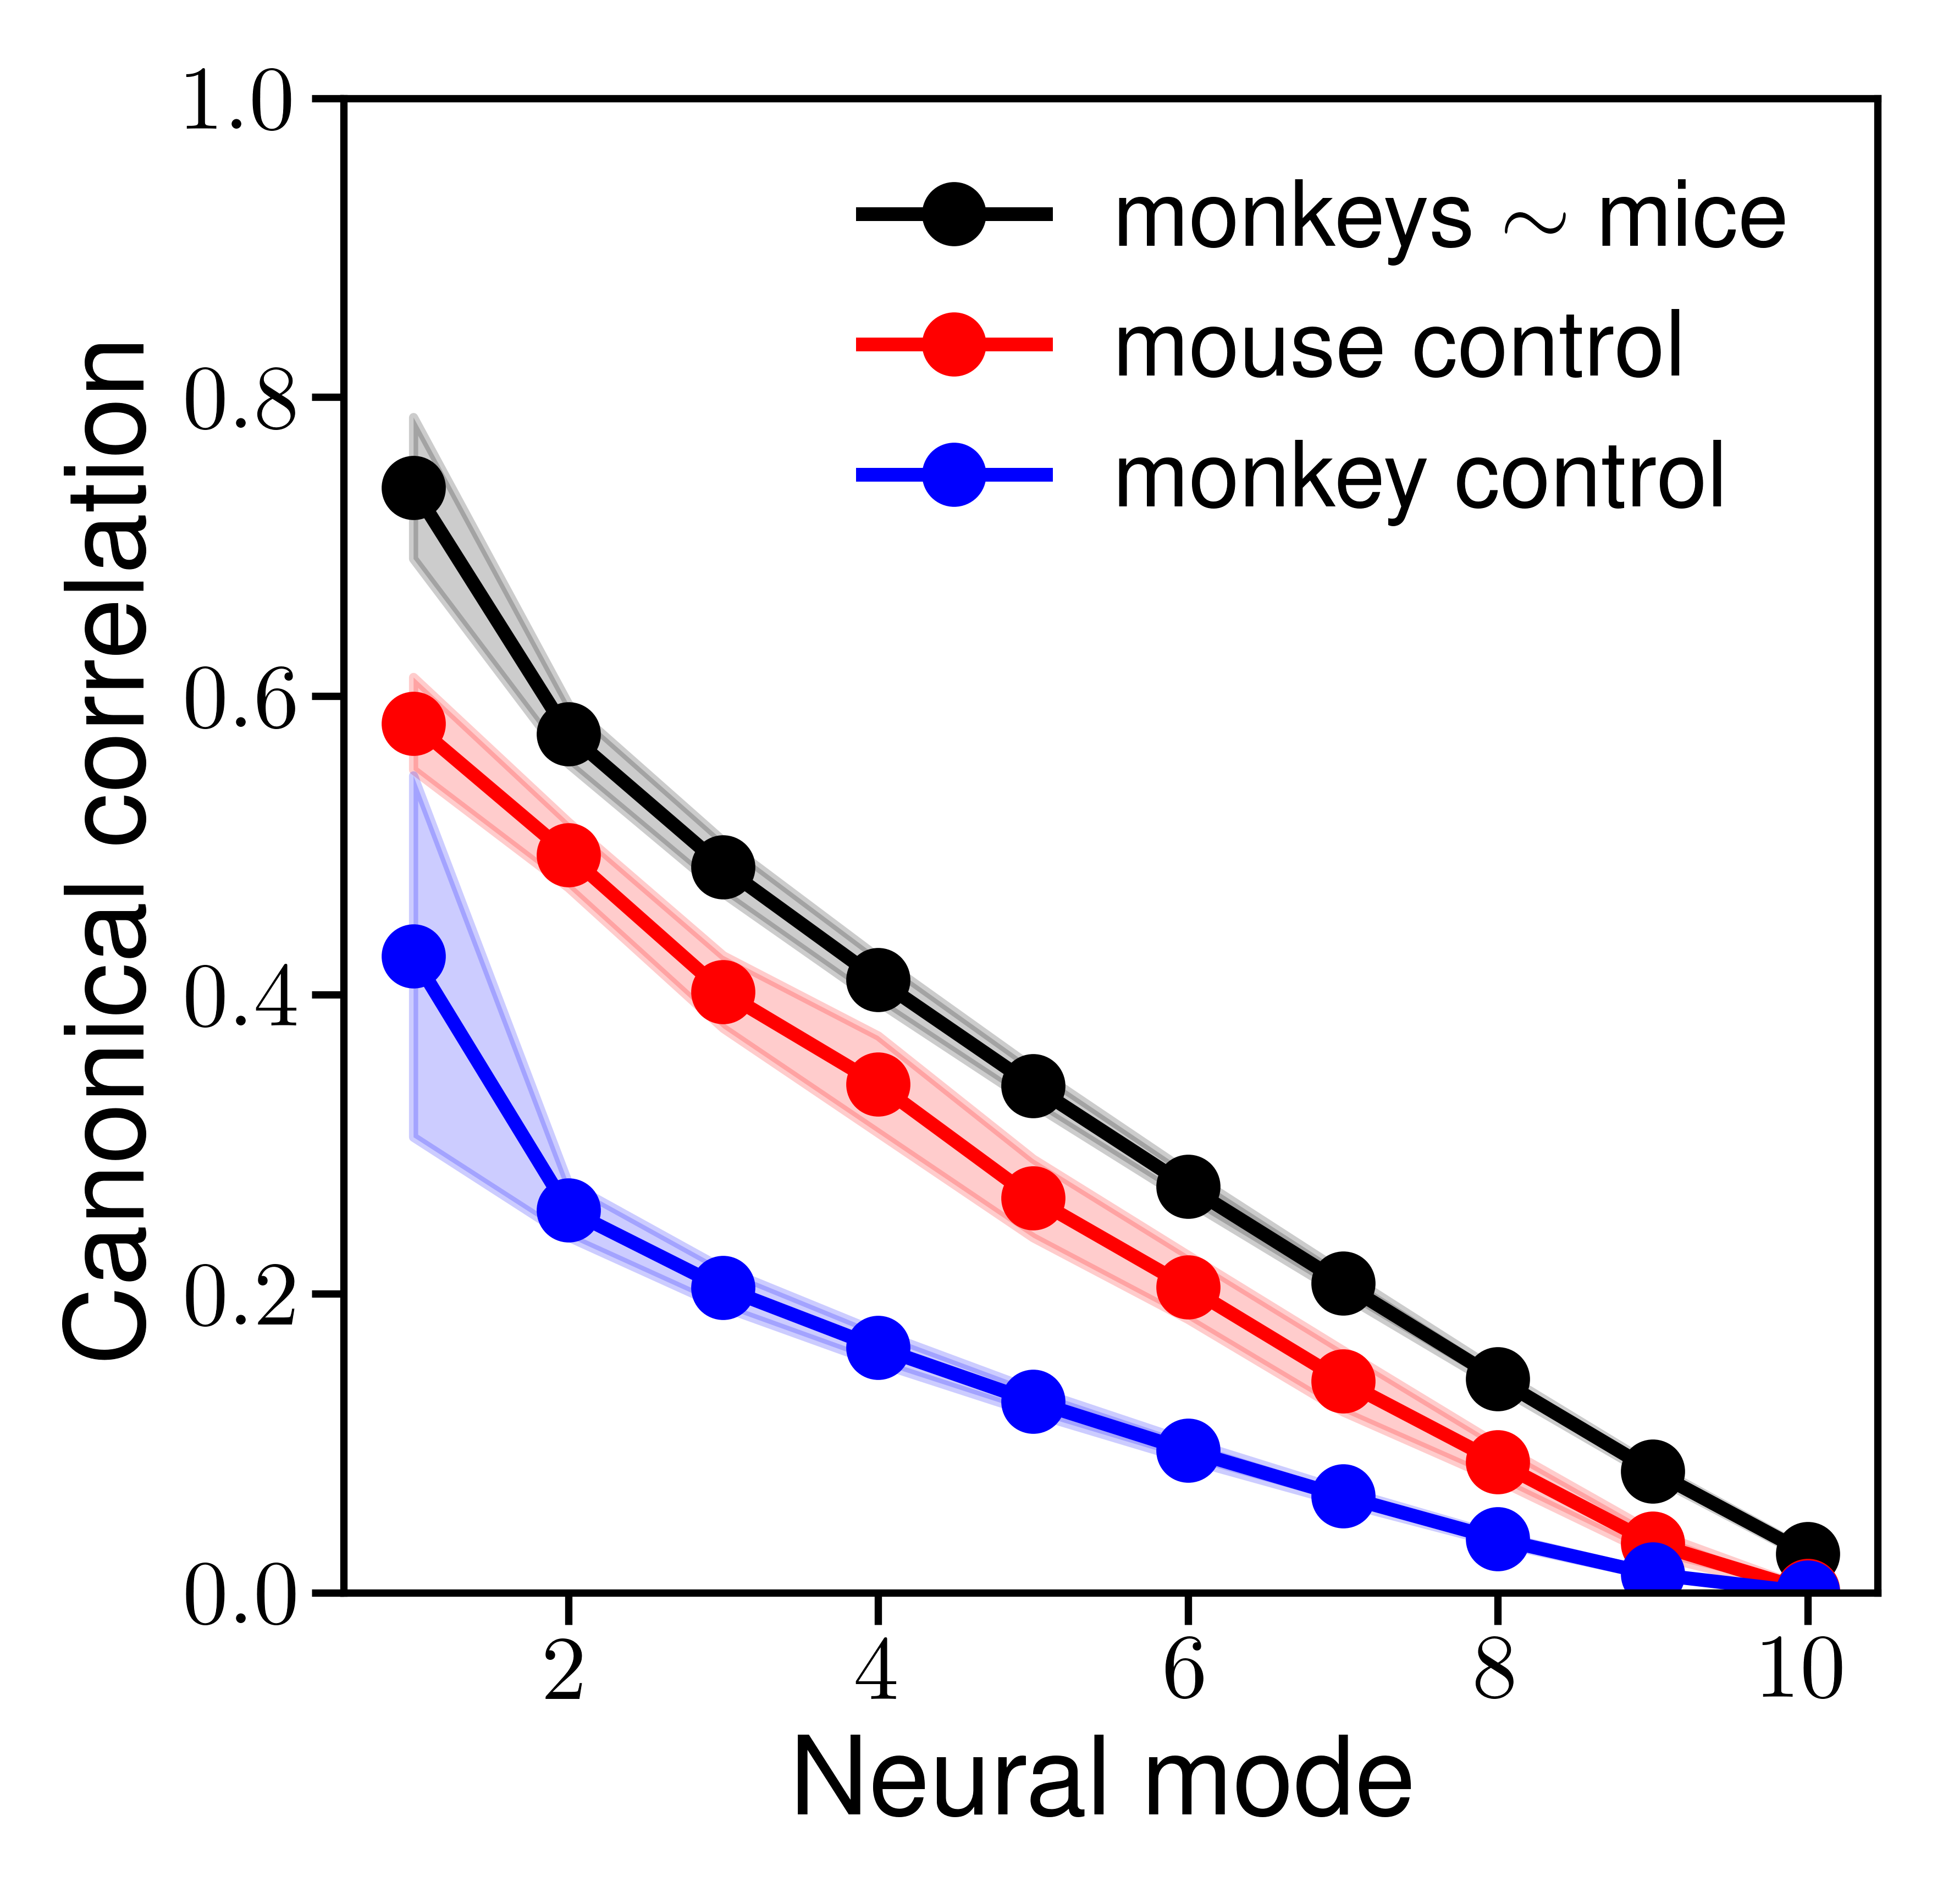

In [9]:
# plot
fig,ax = plt.subplots(figsize=(3,3))
utility.shaded_errorbar(ax, np.arange(1,n_components+1), allCCs, color='k', marker = 'o', label=r'monkeys $\sim$ mice')
utility.shaded_errorbar(ax, np.arange(1,n_components+1), mouse_lower, color='r', marker = 'o', label='mouse control')
utility.shaded_errorbar(ax, np.arange(1,n_components+1), monkey_lower, color='b', marker = 'o', label='monkey control')
ax.set_ylim([0,1])
ax.set_xlabel('Neural mode')
ax.legend()
ax.set_ylabel('Canonical correlation')
# ax.set_title(r'Alignment of monkeys $\sim$ mice');

fig.savefig(params.figPath / 'monkey-mouse-cca.pdf', format='pdf', bbox_inches='tight')

choosing **any** single monkey target to align to the mouse data, improves the correlation values, possibly due to lower condition-dependent signal

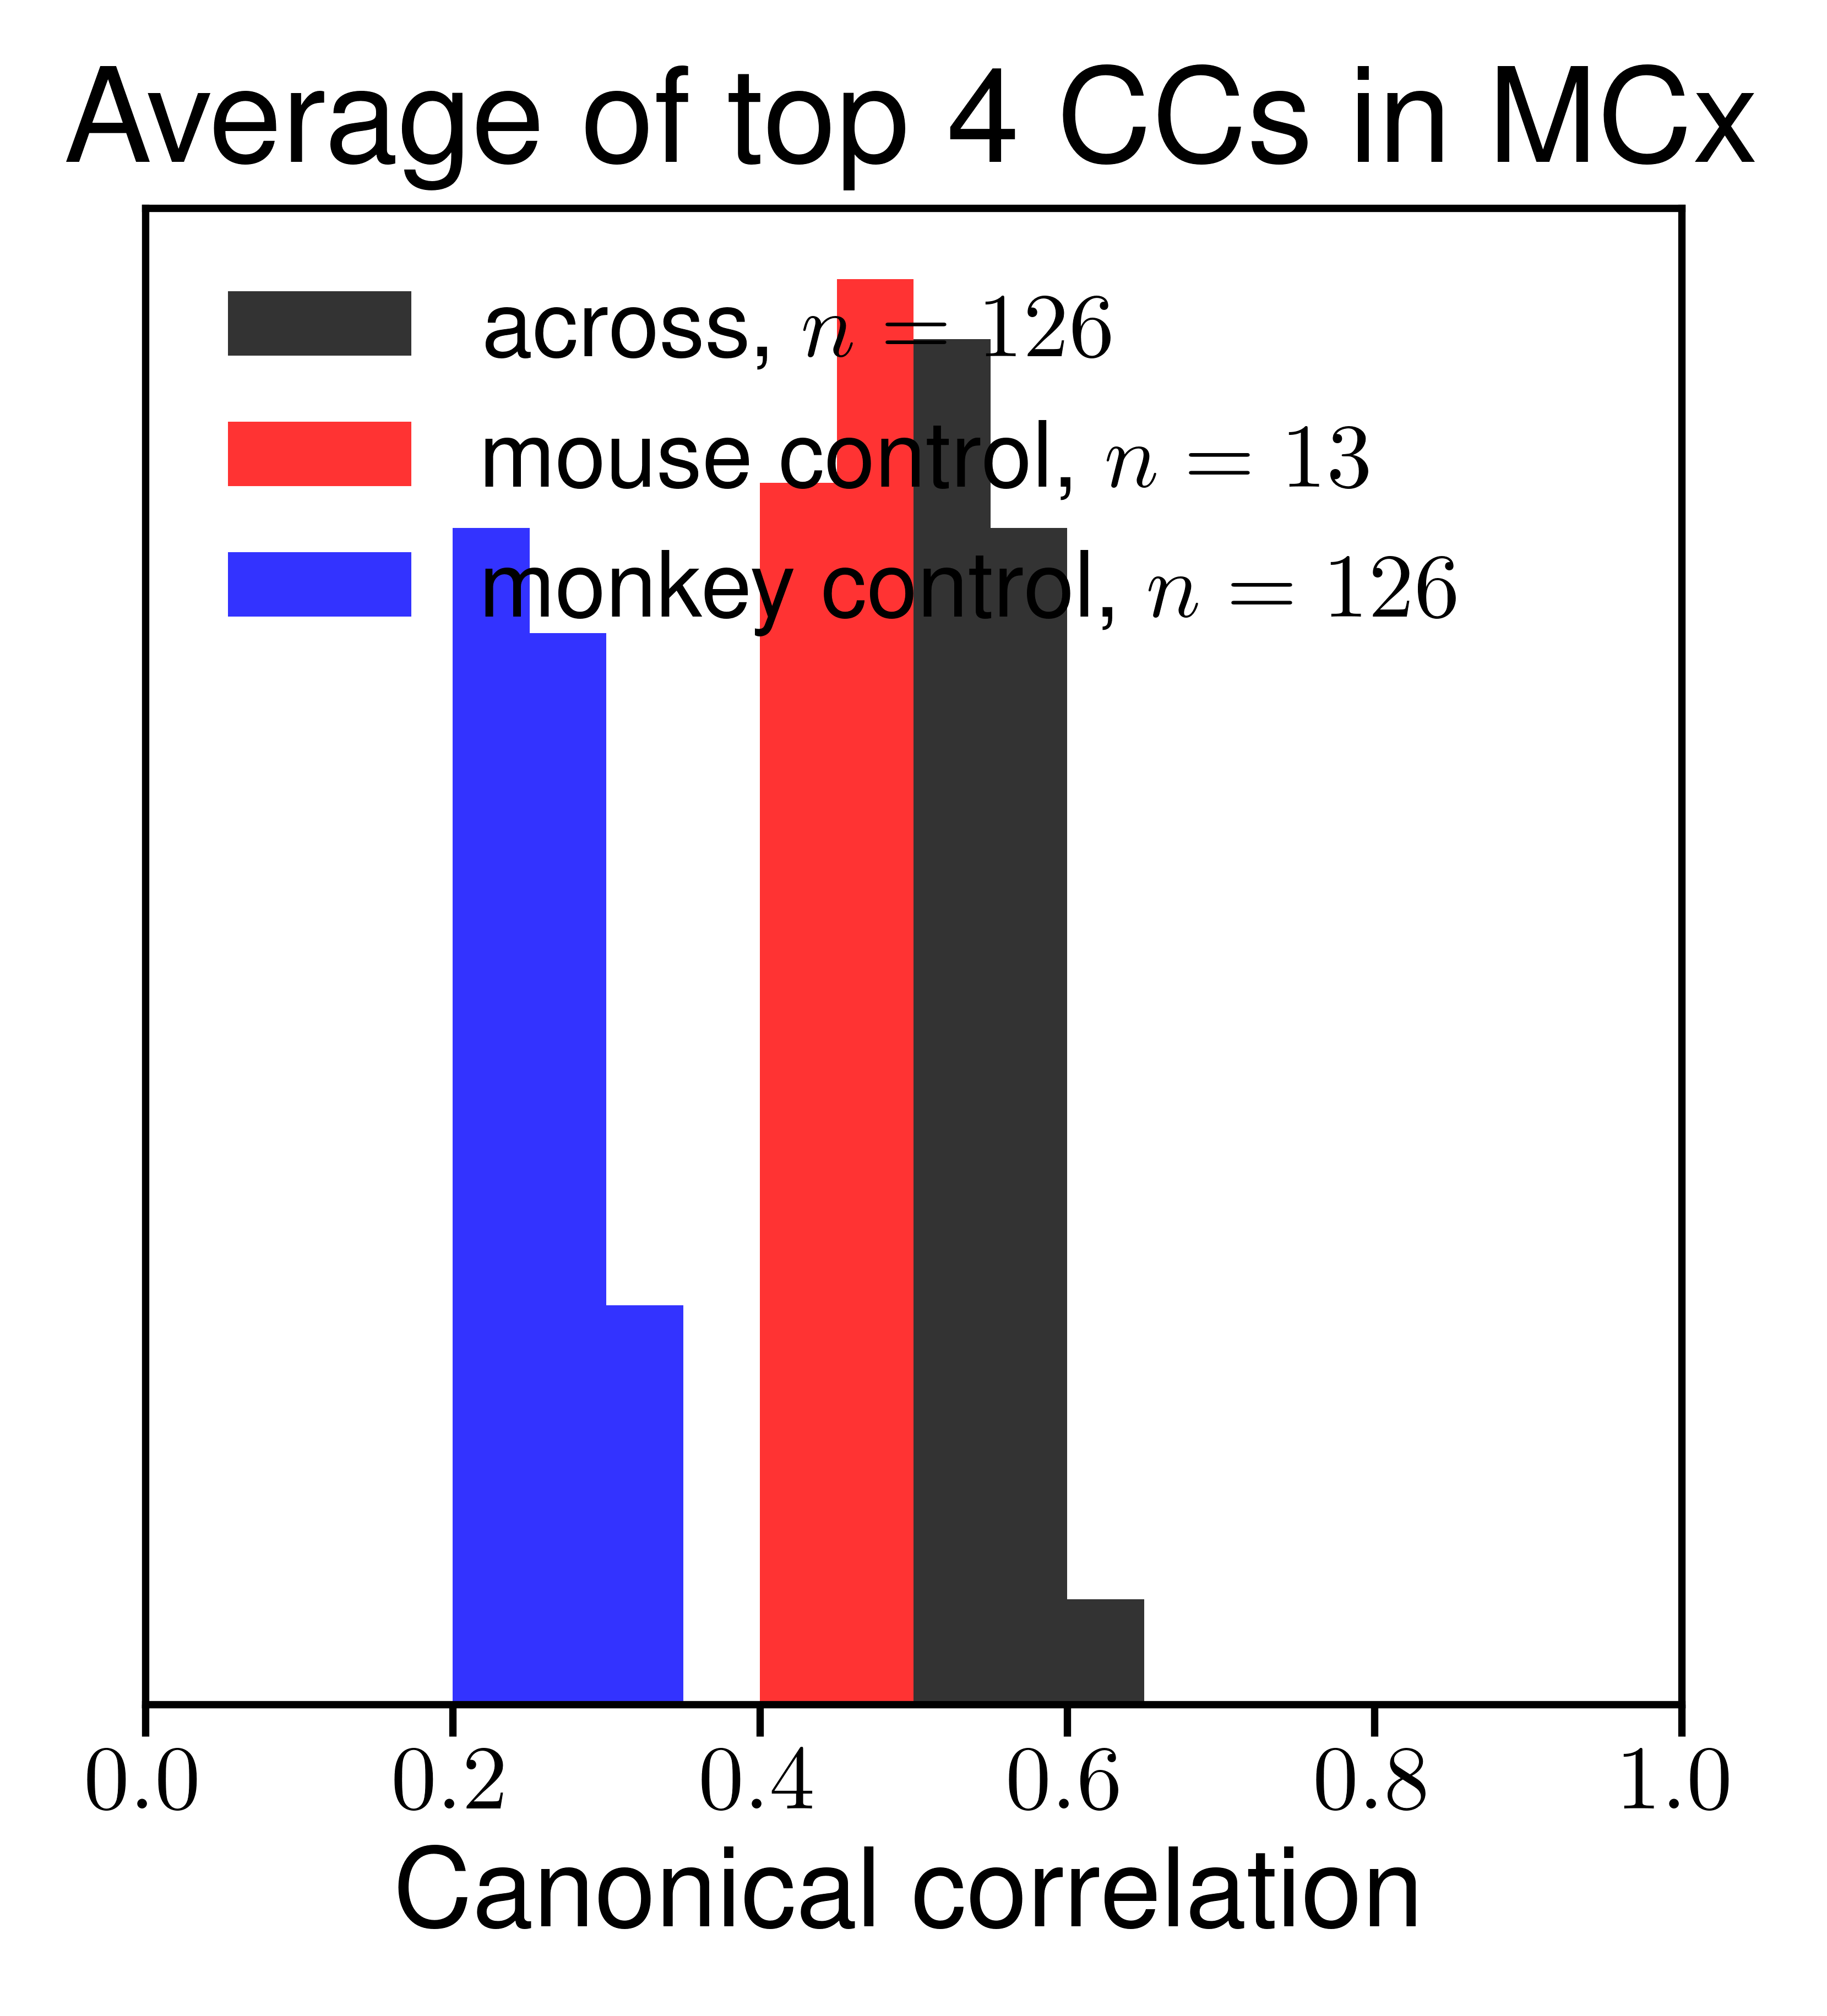

In [13]:
fig,ax = plt.subplots(ncols=1, figsize=(3,3))
bins = np.arange(0,1,0.05)

ax.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True,
        color='k', alpha=.8, label=f'across, $n={allCCs[:4,:].mean(axis=0).shape[0]}$')
ax.hist(mouse_lower[:4,:].mean(axis=0), bins=bins, density=True,
        color='r', alpha=.8, label=f'mouse control, $n={mouse_lower[:4,:].mean(axis=0).shape[0]}$')
ax.hist(monkey_lower[:4,:].mean(axis=0), bins=bins, density=True,
        color='b', alpha=.8, label=f'monkey control, $n={monkey_lower[:4,:].mean(axis=0).shape[0]}$')

ax.set_title(f'Average of top 4 CCs in MCx')
ax.set_xlim([0,1])
ax.set_xlabel('Canonical correlation')
ax.set_yticks([])
ax.legend(loc=2)

fig.savefig(params.figPath / 'monkey-mouse-cca-dist.pdf', format='pdf', bbox_inches='tight')